# **INFERENCE**
___
___

## **INITIALIZATION**

### *IMPORTS*

In [1]:
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.utils as vutils

### *DATA LOADING*

In [2]:
train_df = pd.read_csv("train.csv", index_col=0, names=["val1", "val2", "val3", "val4"])

In [3]:
display(train_df)

,val1,val2,val3,val4
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499
...,...,...,...,...
741,0.001938,0.008833,0.003927,0.005106
742,0.005003,0.018943,0.003057,0.001988
743,0.007683,0.001958,0.007002,0.006467
744,0.003396,0.001280,0.007621,0.001680


___

## **DATA PREPROCESSING**

### *DATA NORMALIZATION*

In [4]:
train_df_normalized = (train_df-train_df.mean())/train_df.std()

In [5]:
display(train_df_normalized)

,val1,val2,val3,val4
0,-0.054470,-0.144799,-0.658635,-0.445863
1,-0.143146,-0.864998,-0.878996,-0.411402
2,-1.050247,-0.473369,-0.572821,-1.147324
3,0.393122,1.313894,-0.173239,-0.364766
4,0.668991,0.582378,-0.013851,0.076110
...,...,...,...,...
741,-0.940601,-0.340562,-0.585969,-0.608536
742,-0.683350,0.522619,-0.679619,-0.942462
743,-0.458394,-0.927581,-0.254648,-0.462799
744,-0.818257,-0.985469,-0.188021,-0.975389


### *DATA VISUALIZATION*

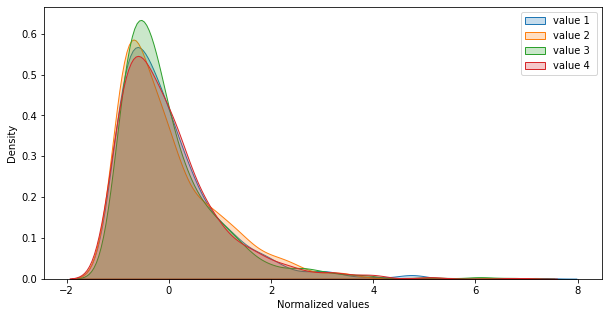

In [6]:
plt.figure(figsize=(10,5))
for column in train_df_normalized.columns:
    sns.kdeplot(train_df_normalized[column], shade=True)
plt.xlabel("Normalized values")
plt.legend(labels=["value 1", "value 2 ", "value 3", "value 4"])
plt.show()

___

## **Basic GAN**

Based on this [GitHub tutorial](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/2019-04-23%20GAN%20Tutorial.ipynb).

### *DEFINING THE NEURAL NETWORKS*

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device: {}".format(device))

device: cuda


In [8]:
class Disciminator(nn.Module):

    def __init__(self, input_size=4):
        super(Disciminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.nl1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(64, 16)
        self.nl2 = nn.LeakyReLU(0.125)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        o = self.nl1(self.fc1(x))
        o = self.nl2(self.fc2(o))
        return torch.sigmoid(self.fc3(o))

In [9]:
class Generator(nn.Module):

    def __init__(self, z_size=50):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_size, 16)
        self.nl1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(16, 64)
        self.nl2 = nn.LeakyReLU(0.125)
        self.fc3 = nn.Linear(64, 4)
    
    def forward(self, x):
        o = self.nl1(self.fc1(x))
        o = self.nl2(self.fc2(o))
        return self.fc3(o)
        

In [10]:
D = Disciminator().to(device)
print(D)

G = Generator().to(device)
print(G)

Disciminator(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (nl1): LeakyReLU(negative_slope=0.25)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (nl2): LeakyReLU(negative_slope=0.125)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=50, out_features=16, bias=True)
  (nl1): LeakyReLU(negative_slope=0.25)
  (fc2): Linear(in_features=16, out_features=64, bias=True)
  (nl2): LeakyReLU(negative_slope=0.125)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


### *TESTING THE NEURAL NETWORKS*

In [11]:
samples = torch.randn(5, 4).to(device)
D(samples)

tensor([[0.5246],
        [0.5054],
        [0.4741],
        [0.4983],
        [0.5166]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [12]:
z_samples = torch.randn(5, 50).to(device)
G(z_samples)

tensor([[-0.1853,  0.2449,  0.2055,  0.1146],
        [-0.1139,  0.1439,  0.1263,  0.1678],
        [-0.1972,  0.2091,  0.0584,  0.0668],
        [-0.1563,  0.2531,  0.0333,  0.1445],
        [-0.1609,  0.0963,  0.0037, -0.0357]], device='cuda:0',
       grad_fn=<AddmmBackward>)

### *DATASET LOADING*

In [13]:
batch_size = 64

features = torch.tensor(train_df_normalized.values).to(device)
true_targets = torch.ones((features.shape[0],1)).to(device)
fake_targets = torch.zeros((features.shape[0],1)).to(device)

train_ds = data_utils.TensorDataset(features, true_targets)
train_ds_loader = data_utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

### *TRAINING THE NETWORKS*

In [14]:
optimizerD = optim.SGD(D.parameters(), lr=0.05)
optimizerG = optim.SGD(G.parameters(), lr=0.05)

In [15]:
criterion = nn.BCELoss()
n_epochs = 10000
fixed_noise = torch.randn(batch_size, 50).to(device)
collect_x_gen = []

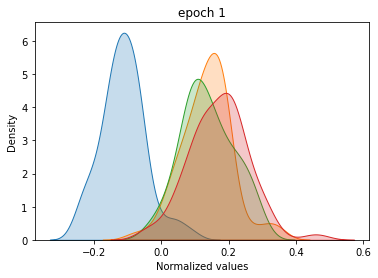

e0 / last mb D(x)=12.0000 D(G(z))=0.4950


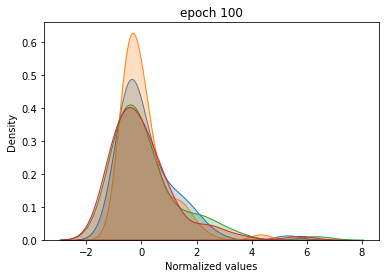

e99 / last mb D(x)=12.0000 D(G(z))=0.4948


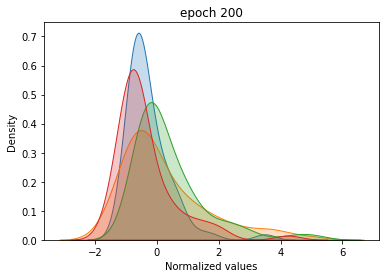

e199 / last mb D(x)=12.0000 D(G(z))=0.5209


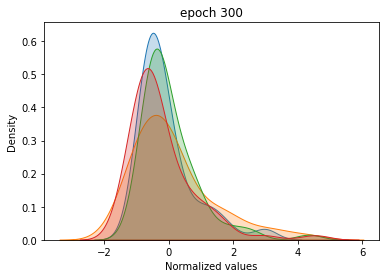

e299 / last mb D(x)=12.0000 D(G(z))=0.4960


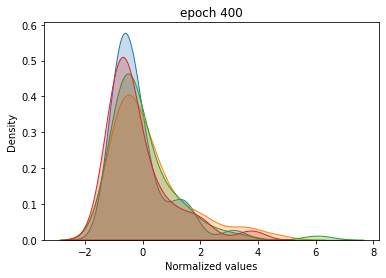

e399 / last mb D(x)=12.0000 D(G(z))=0.5147


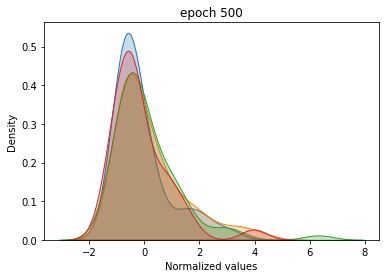

e499 / last mb D(x)=12.0000 D(G(z))=0.5001


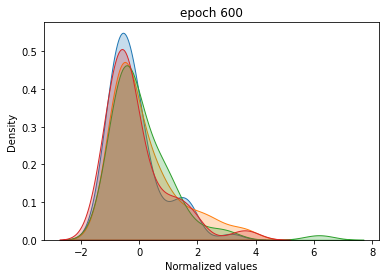

e599 / last mb D(x)=12.0000 D(G(z))=0.4990


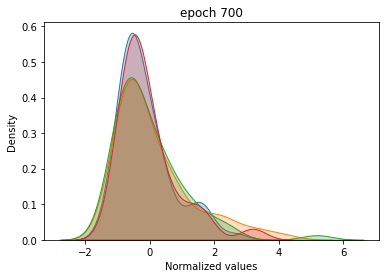

e699 / last mb D(x)=12.0000 D(G(z))=0.5098


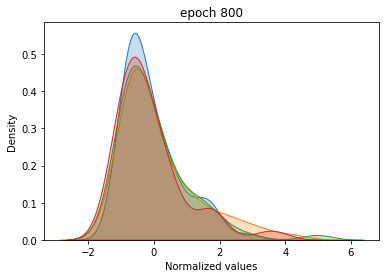

e799 / last mb D(x)=12.0000 D(G(z))=0.4808


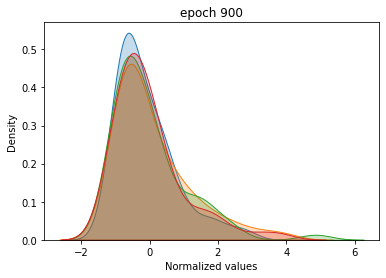

e899 / last mb D(x)=12.0000 D(G(z))=0.4934


In [16]:
for epoch in range(n_epochs):

    for i,data in enumerate(train_ds_loader, 0):

        # STEP 1 : Discriminator optimization step

        optimizerD.zero_grad()

        x_real, y_real = iter(train_ds_loader).next()
        x_real = x_real.float()
        D_x_real = D(x_real)
        lossD_real = criterion(D_x_real, torch.ones((x_real.shape[0],1)).to(device))

        z = torch.randn(batch_size, 50).to(device)
        x_gen = G(z).detach()
        D_x_gen = D(x_gen)
        lossD_fake = criterion(D_x_gen, torch.zeros((x_gen.shape[0],1)).to(device))

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # STEP 2 : Discriminator optimization step

        optimizerG.zero_grad()

        z = torch.randn(batch_size, 50).to(device)
        x_gen = G(z)
        
        D_x_gen = D(x_gen)
        lossG = criterion(D_x_gen, torch.ones((x_gen.shape[0],1)).to(device))

        lossG.backward()
        optimizerG.step()

    if (epoch+1)%100 == 0 or epoch==0:
        x_gen = G(fixed_noise)
        x_gen_df = pd.DataFrame(x_gen.cpu().detach().numpy())
        for column in x_gen_df.columns:
            sns.kdeplot(x_gen_df[column], shade=True)
        plt.title("epoch {}".format(epoch+1))
        plt.xlabel("Normalized values")
        plt.show()
        print("e{} / last mb D(x)={:.4f} D(G(z))={:.4f}".format(
            epoch, len(train_ds_loader), D_x_real.mean().item(), D_x_gen.mean().item()
        ))
    
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

In [ ]:
x=0